## 1. Set up the experiment


Zero-shot superresolution of the `DeepONetStructured` model: From `(31, 31)` grid to `(241, 241)` grid.

### 1-1. Import modules

In [1]:
import  os, time
from    pathlib             import  Path
from    tqdm.notebook       import  tqdm
import  pickle
import  matplotlib.pyplot   as      plt

import  numpy               as  np
import  torch
from    torch.utils.data    import  TensorDataset, DataLoader

import  yaml

from    custom_modules.utils                import  GaussianNormalizer, npzReader
from    custom_modules.pytorch.neuralop     import  DeepONetStructured  as  DeepONet
from    custom_modules.pytorch.torch_utils  import  count_parameters

### 1-2. Load the configurations

In [2]:
with open("config_test.yaml") as f:
    config      = yaml.load(f, Loader = yaml.FullLoader)
    _exp        = config['experiment']
    _data       = config['pde_dataset']
    _deeponet   = config['deeponet']
    train_prefix = config['train_prefix']

### 1-3. Set the experiment

In [3]:
# NOTE Training and data preprocess


BATCH_SIZE      = _exp['batch_size']
TEST_SIZE       = _exp['test_size']
DEVICE          = torch.device(f"cuda:{_exp['cuda_index']}")


RESOLUTION      = _data['resolution']
TEST_PATH       = Path(_data['path'])
TEST_MASK       = np.random.choice(1024, TEST_SIZE, replace = False)


DOWNSAMPLE      = _data['downsample']
GRID            = (RESOLUTION - 1) // DOWNSAMPLE + 1
NUM_NODES       = GRID ** 2
DOWNSAMPLE_TRAIN    = _data['downsample_train']

grid = torch.stack(
            torch.meshgrid(
                torch.linspace(0, 1, GRID),
                torch.linspace(0, 1, GRID),
                indexing = 'ij',
            ),
            dim = -1
        ).type(torch.float)
grid = grid.reshape(-1, 2).to(DEVICE)

In [5]:
### NOTE Model instantiation
def get_path(train_grid: int) -> str:
    return f"{train_prefix}/deeponet_darcy241_res{train_grid}"


deeponet = DeepONet(**_deeponet)
deeponet.load_state_dict(torch.load(get_path(31) + ".pth"))
deeponet.to(DEVICE)

print(f"The number of the parameters in the custom DeepONet\n>>> {count_parameters(deeponet)}")
print(deeponet)

The number of the parameters in the custom DeepONet
>>> 1018881
DeepONet(
    unstructured,
    branch=MLP(layer=(961, 512, 512, 256), bias=True, activation=relu),
    trunk =MLP(layer=(2, 256, 256, 256), bias=True, activation=relu),
)


### * Report the train history

Training time (s): 7.7842e+01 (std: 8.0421e-06)


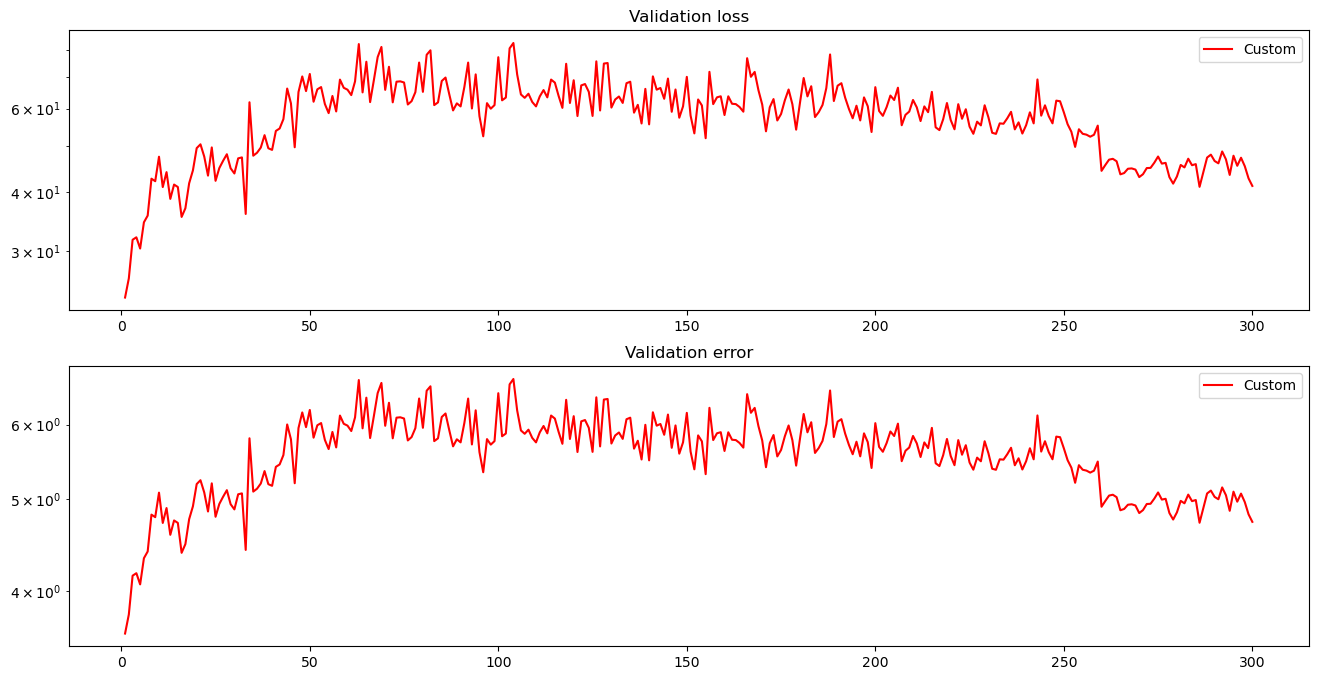

In [6]:
train_loss  = []
train_error = []
val_loss    = []
val_error   = []
train_time  = []

# Train history
for idx in range(1, 11):
    with open(f"{get_path(31)}.pickle", "rb") as f:
        custom_train_history = pickle.load(f)
        train_loss.append(custom_train_history['train_loss'])
        train_error.append(custom_train_history['train_error'])
        val_loss.append(custom_train_history['val_loss'])
        val_error.append(custom_train_history['val_error'])
        train_time.append(custom_train_history['train_time'])

train_loss  = torch.tensor(train_loss,  dtype = torch.float)
train_error = torch.tensor(train_error, dtype = torch.float)
val_loss    = torch.tensor(val_loss,    dtype = torch.float)
val_error   = torch.tensor(val_error,   dtype = torch.float)
train_time  = torch.tensor(train_time,  dtype = torch.float)

# Number of epochs
NUM_TRAIN_EPOCHS = train_loss.size(1)
_epoch_list = np.arange(NUM_TRAIN_EPOCHS) + 1

# Training time
train_time_mean = train_time.mean().item()
train_time_std  = train_time.std().item()
print(f"Training time (s): {train_time_mean:.4e} (std: {train_time_std:.4e})")


# Plot
val_loss_mean   = val_loss.mean(dim = 0)
val_loss_std    = val_loss.std(dim = 0)
val_error_mean  = val_error.mean(dim = 0)
val_error_std   = val_error.std(dim = 0)

fig, axes = plt.subplots(2, 1, figsize = (16, 8))
axes[0].plot(_epoch_list, val_loss_mean, c = 'r', label = "Custom")
axes[0].fill_between(_epoch_list, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, alpha = 0.5)
axes[0].set_title("Validation loss")
axes[0].set_yscale("log")
axes[0].legend()
axes[1].plot(_epoch_list, val_error_mean, c = 'r', label = "Custom")
axes[1].fill_between(_epoch_list, val_error_mean - val_error_std, val_error_mean + val_error_std, alpha = 0.5)
axes[1].set_title("Validation error")
axes[1].set_yscale("log")
axes[1].legend()
plt.show()

## 2. Preprocess data

### 2-1. Instantiate the storages

In [7]:
test_data: dict[str, torch.Tensor]= {
    'coeff':    None,
    'sol':      None,
}

# Normalizers
normalizer = torch.load(f"{get_path(31)}_normalizer.pth")

### 2-2. Load the train data

In [8]:
# Test data
reader = npzReader(TEST_PATH)
for cnt, k in tqdm(enumerate(test_data.keys()), desc = "Preprocessing the test data"):
    # Step 1. Load data
    test_data[k] = torch.from_numpy(reader.get_field(k))
    if k == 'coeff':
        test_data[k] = test_data[k][-TEST_SIZE:, ::DOWNSAMPLE_TRAIN, ::DOWNSAMPLE_TRAIN].flatten(-1)
    else:
        test_data[k] = test_data[k][-TEST_SIZE:, ::DOWNSAMPLE, ::DOWNSAMPLE].flatten(-1)
    test_data[k] = test_data[k].reshape(TEST_SIZE, -1)
    test_data[k] = test_data[k].type(torch.float).to(DEVICE)
    
    # Step 2. Normalize data (NOTE: Uses the normalizers for the train dataset)
    test_data[k] = normalizer[k].encode(test_data[k])

Preprocessing the test data: 0it [00:00, ?it/s]

### 2-3. Instantiate dataloaders

In [9]:
test_dataset = TensorDataset(test_data['coeff'], test_data['sol'])
test_loader  = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

## 3. Test the model

### 3-1. Initialize the loss function

In [10]:
criterion = torch.nn.MSELoss(reduction = 'mean')

### 3-2. Test the model

In [11]:
normalizer['sol'].to(DEVICE)


# NOTE: Test
deeponet.eval()
with torch.no_grad():
    elapsed_time = time.time()

    test_epoch_loss:    torch.Tensor = 0
    test_epoch_error:   torch.Tensor = 0
    for data, target in tqdm(test_loader, desc = "Test"):
        num_data = len(data)
        
        test_pred = deeponet.forward((data, grid))
        test_loss = criterion.forward(test_pred, target)
        
        test_epoch_loss     = test_epoch_loss + test_loss * num_data
        test_pred   = normalizer['sol'].decode(test_pred)
        target      = normalizer['sol'].decode(target)
        test_epoch_error    = test_epoch_error + (
                                    torch.linalg.norm(test_pred - target) / (1e-8 + torch.linalg.norm(target))
                                ) * num_data
    test_epoch_loss     = test_epoch_loss / TEST_SIZE
    test_epoch_error    = test_epoch_error / TEST_SIZE
elapsed_time = time.time() - elapsed_time

print(f"* Elapsed time: {elapsed_time:.3f} seconds")
print(f"* Test loss:    {test_epoch_loss.item():.4e}")
print(f"* L^2 error:    {test_epoch_error.item():.4e}")

Test:   0%|          | 0/32 [00:00<?, ?it/s]

RuntimeError: einsum(): the number of subscripts in the equation (3) does not match the number of dimensions (2) for operand 1 and no ellipsis was given

### 3-3. Plot some examples

In [ ]:
example_idx = 0
fig, axes = plt.subplots(2, 2, figsize = (12, 12))
example_y    = target[example_idx].cpu().squeeze(-1).reshape(GRID, GRID)
example_pred = test_pred[example_idx].cpu().squeeze(-1).reshape(GRID, GRID)

im = axes[0, 0].imshow(example_y)
axes[0, 0].set_title("Truth")
plt.colorbar(im, ax = axes[0, 0])

im = axes[0, 1].imshow(example_pred)
axes[0, 1].set_title("Prediction")
plt.colorbar(im, ax = axes[0, 1])

im = axes[1, 0].imshow((example_pred - example_y).abs())
axes[1, 0].set_title("$|(pred) - (truth)|$")
plt.colorbar(im, ax = axes[1, 0])

_vmax = 0.4
im = axes[1, 1].imshow((example_pred - example_y).abs() / example_y.abs(), vmax = _vmax)
axes[1, 1].set_title(f"$|(pred) - (truth)| / |(truth)|$ (bounded by {_vmax})")
plt.colorbar(im, ax = axes[1, 1])

plt.show()

## End of file